In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import fiftyone as fo
import fiftyone.zoo as foz
from PIL import Image
import json
from pathlib import Path
from torch.utils.data import Dataset, IterableDataset
import tqdm
from transformers import CLIPTokenizer
from torchvision.transforms.functional import to_tensor, to_pil_image
import random
import torch
from torch.nn.utils.rnn import pad_sequence

In [3]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations", "captions"],
    max_samples=50,
    shuffle=True,
)
dataset.compute_metadata()

Found annotations at '/home/lukovdg1/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
# load captions
captiondb = {}   # from image_id to list of captions
captionfiles = ["/USERSPACE/lukovdg1/controlnet11/coco/annotations/captions_val2014.json", "/USERSPACE/lukovdg1/controlnet11/coco/annotations/captions_train2014.json"]
for captionfile in captionfiles:
    captions = json.load(open(captionfile))
    for annotation in captions["annotations"]:
        imgid = annotation["image_id"]
        if imgid not in captiondb:
            captiondb[imgid] = []
        captiondb[imgid].append(annotation["caption"])

In [5]:
class ProcessedCOCOExample(object):
    def __init__(self, img_path, captions, regions):
        super().__init__()
        self.image_path = img_path
        self.captions = captions
        self.regions = regions
        
        
def _img_importance_flatten(img: torch.tensor, w: int, h: int) -> torch.tensor:
    return torch.nn.functional.interpolate(
        img.unsqueeze(0).unsqueeze(1),
        # scale_factor=1 / ratio,
        size=(w, h),
        mode="bilinear",
        align_corners=True,
    ).squeeze()
        

class COCODataset(Dataset):
    def __init__(self, split="valid", maxmasks=20, max_samples=100,
                 captionpath="/USERSPACE/lukovdg1/controlnet11/coco/annotations/", 
                 tokenizer_version="openai/clip-vit-large-patch14"):
        super().__init__()
        self.maxmasks = maxmasks
        self.tokenizer = CLIPTokenizer.from_pretrained(tokenizer_version)
        
        self.captiondb = {}   # from image_id to list of captions
        captionfiles = [captionpath + "captions_val2014.json", captionpath + "captions_train2014.json"]
        for captionfile in captionfiles:
            captions = json.load(open(captionfile))
            for annotation in captions["annotations"]:
                imgid = annotation["image_id"]
                if imgid not in self.captiondb:
                    self.captiondb[imgid] = []
                self.captiondb[imgid].append(annotation["caption"])
                
        if split.startswith("val"):
            segdata = foz.load_zoo_dataset(
                "coco-2017",
                split="validation",
                max_samples=max_samples,
                label_types=["segmentations"],
                shuffle=False,
            )
            segdata.compute_metadata()
        elif split.startswith("tr"):
            segdata = foz.load_zoo_dataset(
                "coco-2017",
                split="train",
                label_types=["segmentations"],
                max_samples=max_samples,
                shuffle=False,
            )
            segdata.compute_metadata()
            
        self.examples = []
        numtoomanyregions = 0
        
        for example in tqdm.tqdm(segdata):
            image_path = example.filepath
            image_id = int(Path(example.filepath).stem)

            captions = captiondb[image_id]
            captions = [self.tokenize([caption]) for caption in captions]
            frame_size = (example.metadata["width"], example.metadata["height"])
            
            if example.ground_truth is None:
                continue
                
            regions = []
            # prevent overlapping masks by zeroing out the regions that come later where they overlap with earlier ones
            runningmask = None
            for region in example.ground_truth.detections:
                segmentation = region.to_segmentation(frame_size=frame_size)
                segmask = torch.tensor(segmentation.mask, dtype=torch.bool)
                if runningmask is None:
                    runningmask = torch.zeros_like(segmask)
                segmask = segmask & (~runningmask)
                regions.append((segmask, self.tokenize([region.label])))
                runningmask = runningmask | segmask

            if len(regions) > maxmasks:
                numtoomanyregions += 1
                continue
                
            self.examples.append(ProcessedCOCOExample(image_path, captions, regions))     
#         print(f"Retained examples: {len(self.examples)}")
#         print(f"Too many regions: {numtoomanyregions}")

    def tokenize(self, x, tokenizer=None):
        tokenizer = tokenizer if tokenizer is not None else self.tokenizer
        tokenized = tokenizer(x,  # padding="max_length",
                                  max_length=tokenizer.model_max_length,
                                  return_overflowing_tokens=False,
                                  truncation=True,
                                  return_tensors="pt")
        return tokenized["input_ids"]
    
    def untokenize(self, x, tokenizer=None):
        tokenizer = tokenizer if tokenizer is not None else self.tokenizer
        ret = tokenizer.decode(x)
        return ret
                
    def __getitem__(self, item):
        example = self.examples[item]
        # materialize one example
        # 3. load image
        img = Image.open(example.image_path)
        imgtensor = to_tensor(img)
        # 1. pick one caption at random (TODO: or generate one from regions)
        captions = [random.choice(example.captions)[0]]
        # initialize layer ids
        layerids = [torch.zeros_like(captions[0])]
        # 4. load masks
        masks = [torch.ones_like(imgtensor[0], dtype=torch.bool)]
        # 2. get the captions of the regions and build layer ids
        for i, region in enumerate(example.regions):
            captions.append(region[1][0])
            layerids.append(torch.ones_like(region[1][0]) * (i + 1))
            masks.append(region[0])
        # finalize captions and layer ids
#         caption, layerids = torch.cat(captions, 0), torch.cat(layerids, 0)

        # random square crop of size divisble by 64 and maximum size 512
        cropsize = min((min(imgtensor[0].shape) // 64) * 64, 512)
        crop = (random.randint(0, imgtensor.shape[1] - cropsize), 
                random.randint(0, imgtensor.shape[2] - cropsize))
        print(cropsize)
        
        imgtensor = imgtensor[:, crop[0]:crop[0]+cropsize, crop[1]:crop[1]+cropsize]
        masks = [maske[crop[0]:crop[0]+cropsize, crop[1]:crop[1]+cropsize] for maske in masks]
        
        
        # compute downsampled versions of the layer masks
        downsamples = [cropsize // e for e in [8, 16, 32, 64]]
        downmaskses = []
        for mask in masks:
            downmasks = {}
            for downsample in downsamples:
                downsampled = _img_importance_flatten(mask.float(), downsample, downsample)
                downmasks[tuple(downsampled.shape)] = downsampled
            downmaskses.append(downmasks)
            
        # concatenate masks in one tensor
        downmasktensors = {}
        for downmasks in downmaskses:
            for res, downmask in downmasks.items():
                if res not in downmasktensors:
                    downmasktensors[res] = []
                downmasktensors[res].append(downmask)
        downmasktensors = {k: torch.stack(v, 0) for k, v in downmasktensors.items()}
        
        return {"image": imgtensor, 
                "captions": captions,
                "layerids": layerids,
                "regionmasks": downmasktensors
               }
    
    def __len__(self):
        return len(self.examples)
    
    @classmethod
    def collate_fn(examples):
        # every example is dictionary like specified above
        # TODO
        images = []
        captions = []
        regionmasks = []
        layerids = []
        regioncounts = []
        for example in examples:
            images.append(example["image"])   # concat images
            captions = captions + example["captions"]   # batchify captions
            regioncounts.append(len(example["captions"]))  # keep track of the number of regions per example
            layerids = layerids + example["layerids"]   # layer ids
            
        imagebatch = torch.stack(images, dim=0)
        captionbatch = pad_sequence(captions, batch_first=True)
        layeridsbatch = pad_sequence(layerids, batch_first=True)
        return {"image": imagebatch, "captions": captionsbatch, "layerids": layeridsbatch}

In [6]:
cocodataset = COCODataset(max_samples=100)
print(len(cocodataset))

Found annotations at '/home/lukovdg1/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.85it/s]

96


In [7]:
cocodataset.__class__ = COCODataset
cocodataset[4]

384


{'image': tensor([[[0.7882, 0.7333, 0.7216,  ..., 0.4941, 0.4275, 0.4902],
          [0.7686, 0.7098, 0.8157,  ..., 0.4196, 0.4471, 0.4588],
          [0.7333, 0.7804, 0.7333,  ..., 0.4392, 0.3804, 0.4235],
          ...,
          [0.5412, 0.5804, 0.4824,  ..., 0.3020, 0.3098, 0.3137],
          [0.6235, 0.7765, 0.7608,  ..., 0.3020, 0.2627, 0.2863],
          [0.5373, 0.5294, 0.6196,  ..., 0.2627, 0.2706, 0.3176]],
 
         [[0.6902, 0.6784, 0.6588,  ..., 0.2902, 0.1961, 0.2706],
          [0.6667, 0.6627, 0.8000,  ..., 0.2000, 0.2157, 0.2392],
          [0.6667, 0.6784, 0.6510,  ..., 0.2196, 0.1686, 0.2157],
          ...,
          [0.2588, 0.3373, 0.2706,  ..., 0.5020, 0.5176, 0.5059],
          [0.2431, 0.4941, 0.6078,  ..., 0.5020, 0.4706, 0.4784],
          [0.1882, 0.1529, 0.2078,  ..., 0.4745, 0.4824, 0.5098]],
 
         [[0.5686, 0.5647, 0.5255,  ..., 0.1333, 0.0627, 0.1333],
          [0.5686, 0.5765, 0.6941,  ..., 0.0549, 0.0902, 0.1098],
          [0.4980, 0.5725, 0.46

384
torch.Size([3, 384, 384])


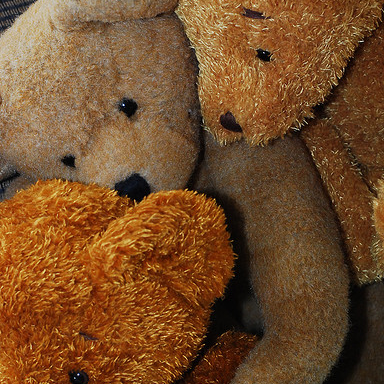

<|startoftext|>three stuffed animals are sitting on a bed. <|endoftext|>
(48, 48)
torch.Size([5, 48, 48])


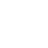

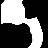

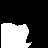

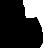

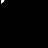

(24, 24)
torch.Size([5, 24, 24])


(12, 12)
torch.Size([5, 12, 12])


(6, 6)
torch.Size([5, 6, 6])


In [8]:
x = cocodataset[4]
print(x["image"].shape)
display(to_pil_image(x["image"]))
print(cocodataset.tokenizer.decode(x["captions"][0]))
for maskdim, mask in x["regionmasks"].items():
    print(maskdim)
    print(mask.shape)
    for i in range(len(mask)):
        display(to_pil_image(mask[i]))
# print(x["masks"][1].float().shape)
# display(to_pil_image(x["masks"][1].float()))

In [ ]:
i = 0
for example in dataset:
    # print(example)
    image_id = int(Path(example.filepath).stem)
    print(image_id)
    captions = captiondb[image_id]
    print(json.dumps(captions, indent=3))
    display(Image.open(example.filepath))
    
    frame_size = (example.metadata["width"], example.metadata["height"])
    for det in example.ground_truth.detections:
        segmentation = det.to_segmentation(frame_size=frame_size)
        full_img_mask = segmentation.mask
        print(full_img_mask.shape)
        print(det.label)
        display(Image.fromarray(full_img_mask))
    i += 1
    if i > 50:
        break

In [17]:
import os

import cv2
import numpy as np

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

def extract_classwise_instances(samples, output_dir, label_field, ext=".png"):
    print("Extracted object instances...")
    for sample in samples.iter_samples(progress=True):
        img = cv2.imread(sample.filepath)
        img_h,img_w,c = img.shape
        for det in sample[label_field].detections:
            mask = det.mask
            [x,y,w,h] = det.bounding_box
            x = int(x * img_w)
            y = int(y * img_h)
            h, w = mask.shape
            mask_img = img[y:y+h, x:x+w, :] 
            alpha = mask.astype(np.uint8)*255
            alpha = np.expand_dims(alpha, 2)
            mask_img = np.concatenate((mask_img, alpha), axis=2)
    
            label = det.label
            label_dir = os.path.join(output_dir, label)
            if not os.path.exists(label_dir):
                os.mkdir(label_dir)
            output_filepath = os.path.join(label_dir, det.id+ext)
            cv2.imwrite(output_filepath, mask_img)

label_field = "ground_truth"
classes = ["person"]

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=classes,
    max_samples=20,
    label_field=label_field,
    dataset_name=fo.get_default_dataset_name(),
)

view = dataset.filter_labels(label_field, F("label").is_in(classes))

output_dir = "/tmp/coco-segmentations"
os.makedirs(output_dir, exist_ok=True)

extract_classwise_instances(view, output_dir, label_field)

Found annotations at '/home/lukovdg1/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 20/20 [284.2ms elapsed, 0s remaining, 70.4 samples/s]     
Dataset '2023.07.07.15.04.43' created
Extracted object instances...
 100% |███████████████████| 20/20 [263.3ms elapsed, 0s remaining, 76.0 samples/s]      
